# Raster

The ````raster```` package is the main R package to work with raster data (mainly geospatial rasters, but it works fine with general images).

In [1]:
install.packages("raster", dependencies = TRUE)
library("raster")

set.seed(42)
options(repr.plot.width=6, repr.plot.height=2)

also installing the dependencies 'irlba', 'latticeExtra', 'sp', 'rgdal', 'rgeos', 'ncdf4', 'igraph', 'rasterVis'



package 'irlba' successfully unpacked and MD5 sums checked
package 'latticeExtra' successfully unpacked and MD5 sums checked
package 'sp' successfully unpacked and MD5 sums checked
package 'rgdal' successfully unpacked and MD5 sums checked
package 'rgeos' successfully unpacked and MD5 sums checked
package 'ncdf4' successfully unpacked and MD5 sums checked
package 'igraph' successfully unpacked and MD5 sums checked
package 'rasterVis' successfully unpacked and MD5 sums checked
package 'raster' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Joe\AppData\Local\Temp\RtmpUl5FTf\downloaded_packages


Loading required package: sp


## Data Structure

The main tripping point is that the objects the library uses have a layer of abstraction between the object and the data (this means they can point to raster files that are larger than working memory). Objects can live in memory, but this setup allows them to be handled in the same way, regardless of source.

It's easy to get at the values in a raster, but for massive files that may cause issues. Even on powerful machines R imposes [it's own limits too](https://stat.ethz.ch/R-manual/R-devel/library/base/html/Memory-limits.html) - these are currently in the gigabyte range.

class       : RasterLayer 
dimensions  : 115, 80, 9200  (nrow, ncol, ncell)
resolution  : 40, 40  (x, y)
extent      : 178400, 181600, 329400, 334000  (xmin, xmax, ymin, ymax)
coord. ref. : +init=epsg:28992 +towgs84=565.237,50.0087,465.658,-0.406857,0.350733,-1.87035,4.0812 +proj=sterea +lat_0=52.15616055555555 +lon_0=5.38763888888889 +k=0.9999079 +x_0=155000 +y_0=463000 +ellps=bessel +units=m +no_defs 
data source : D:\Anaconda3\Lib\R\library\raster\external\test.grd 
names       : test 
values      : 128.434, 1805.78  (min, max)

class       : RasterBrick 
dimensions  : 77, 101, 7777, 3  (nrow, ncol, ncell, nlayers)
resolution  : 1, 1  (x, y)
extent      : 0, 101, 0, 77  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=merc +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0 
data source : D:\Anaconda3\Lib\R\library\raster\external\rlogo.grd 
names       : red, green, blue 
min values  :   0,     0,    0 
max values  : 255,   255,  255 



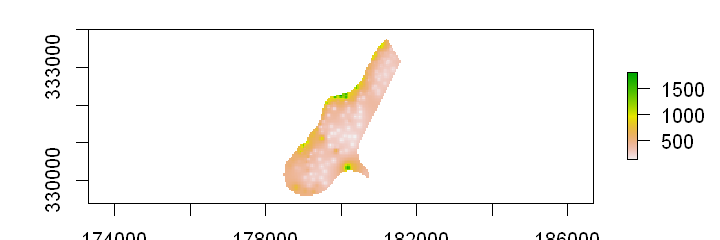

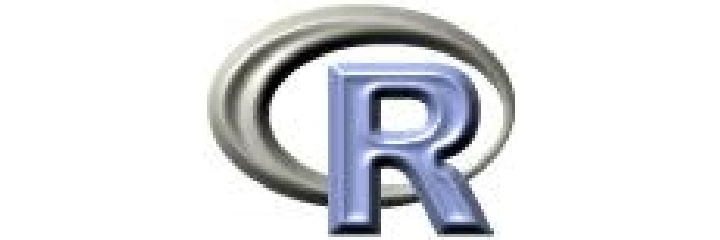

In [2]:
test_layer <- raster(system.file("external/test.grd", package="raster"))
test_brick <- brick(system.file("external/rlogo.grd", package="raster"))

print(test_layer)
print(test_brick)
plot(test_layer)
plotRGB(test_brick)

## Data Types

The three main data types in the raster package are:

* RasterLayer
    * This is a single layer raster.
    * Created with the ````raster()```` function.
    * If pointed at a file with multiple layers, it will take the first by default (can be changed with ````band = 2```` ect when defining it).
* RasterBrick
    * Multi-layer raster.
    * From a single source.
    * Fairly strict restrictions on metadata (resolution etc).
* RasterStack
    * Multi-layer raster.
    * Created with the ````stack()```` function.
    * More freeform than RasterBrick.
    * Can only exist in memory and is generally not returned unless specified.
    * Somewhat analagous to a virtual raster.

Colectively these are referred to as ````Raster*```` objects.

## Accessing Data

### Values

The simplest way of accessing data is with the ````values```` function, this creates a vector (layer) or matrix (brick / stack) of values.

This may cause issues if used indiscriminately due to holding big lumps of data in memory - but has the distinct advantage of being able to throw most R analytical libraries at a problem (and the speed increases of not having to go back to disc repeatedly).

In [3]:
print(head(values(test_layer)))
print(head(values(test_brick)))

[1] NA NA NA NA NA NA
     red green blue
[1,] 255   255  255
[2,] 255   255  255
[3,] 255   255  255
[4,] 255   255  255
[5,] 255   255  255
[6,] 255   255  255


### Calc

Another way of working is the ````calc```` function - which is similar to the ````apply```` family of functions, taking a raster\* object and a function:

class       : RasterLayer 
dimensions  : 115, 80, 9200  (nrow, ncol, ncell)
resolution  : 40, 40  (x, y)
extent      : 178400, 181600, 329400, 334000  (xmin, xmax, ymin, ymax)
coord. ref. : +init=epsg:28992 +towgs84=565.237,50.0087,465.658,-0.406857,0.350733,-1.87035,4.0812 +proj=sterea +lat_0=52.15616055555555 +lon_0=5.38763888888889 +k=0.9999079 +x_0=155000 +y_0=463000 +ellps=bessel +units=m +no_defs 
data source : in memory
names       : layer 
values      : 0, 2.998993  (min, max)



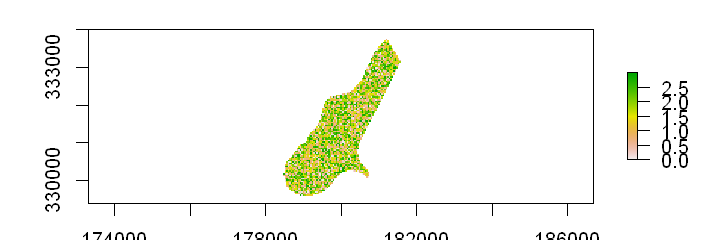

In [4]:
calc_test <- calc(test_layer, function(x) x %% 3)
print(calc_test)
plot(calc_test)

### getValues, setValues

The comprehensive way to work with values out of a raster is ````getValues```` and ````setValues```` that allow access to a block of data. The ````blockSize```` function can help in defining an appropriate size of block.

## Metadata

````raster*```` objects can the normal metadata for a geospatial raster file:

### Class

What kind of ````raster*````  object is it (layer, brick or stack).

### Dimensions

Dimensions - How large is it.

* All objects have row count, column count and cell count.
* Stacks & bricks have layer count too.

### Resolution

The size of the cells along each axis.
    * This is in the units of the projection system.
    * For non-spatial data this will just be 1 (unitless).

### Extent

The outer bounds of the raster (can also be thought of as the position of the lower left and upper right corners).
    * For non-spatial data this will just be 1, 1 at the lower corner and the number of rows / columns a the upper corner.

Extents can be accessed with:

In [5]:
extent(test_layer)

class       : Extent 
xmin        : 178400 
xmax        : 181600 
ymin        : 329400 
ymax        : 334000 

### Coordinate Reference System

The coordinate system being used for the raster, the default seems to be Mercator Projection on the WGS84 elipsoid (having the effect of dividing the globe into the relevant number of rows / columns).

This is output as a Proj4 string, but is a ````crs```` object. The coordinate system can be accessed with:

In [6]:
crs(test_layer)

CRS arguments:
 +init=epsg:28992
+towgs84=565.237,50.0087,465.658,-0.406857,0.350733,-1.87035,4.0812
+proj=sterea +lat_0=52.15616055555555 +lon_0=5.38763888888889
+k=0.9999079 +x_0=155000 +y_0=463000 +ellps=bessel +units=m +no_defs 

And can be set with:

In [7]:
# crs(x) <- [new CRS here]

Though this should *only* be done to set / correct a crs that hasn't been imported properly.

Just assigning a new crs will overwrite the crs *without* reprojecting. It will just use the old coordinates in the new system.

Reprojection is handled by ````projectRaster````, which can take a ````crs```` object directly or a ````raster*```` to take one from:

In [8]:
reproj_raster = projectRaster(from = test_brick, crs = crs(test_layer))
print(reproj_raster)

class       : RasterBrick 
dimensions  : 92, 114, 10488, 3  (nrow, ncol, ncell, nlayers)
resolution  : 1.24, 1.24  (x, y)
extent      : -587797.7, -587656.3, -5732789, -5732675  (xmin, xmax, ymin, ymax)
coord. ref. : +init=epsg:28992 +towgs84=565.237,50.0087,465.658,-0.406857,0.350733,-1.87035,4.0812 +proj=sterea +lat_0=52.15616055555555 +lon_0=5.38763888888889 +k=0.9999079 +x_0=155000 +y_0=463000 +ellps=bessel +units=m +no_defs 
data source : in memory
names       :        red,      green,       blue 
min values  : 0.00000000, 0.05110064, 0.04156861 
max values  :   299.3860,   299.0217,   297.5823 

